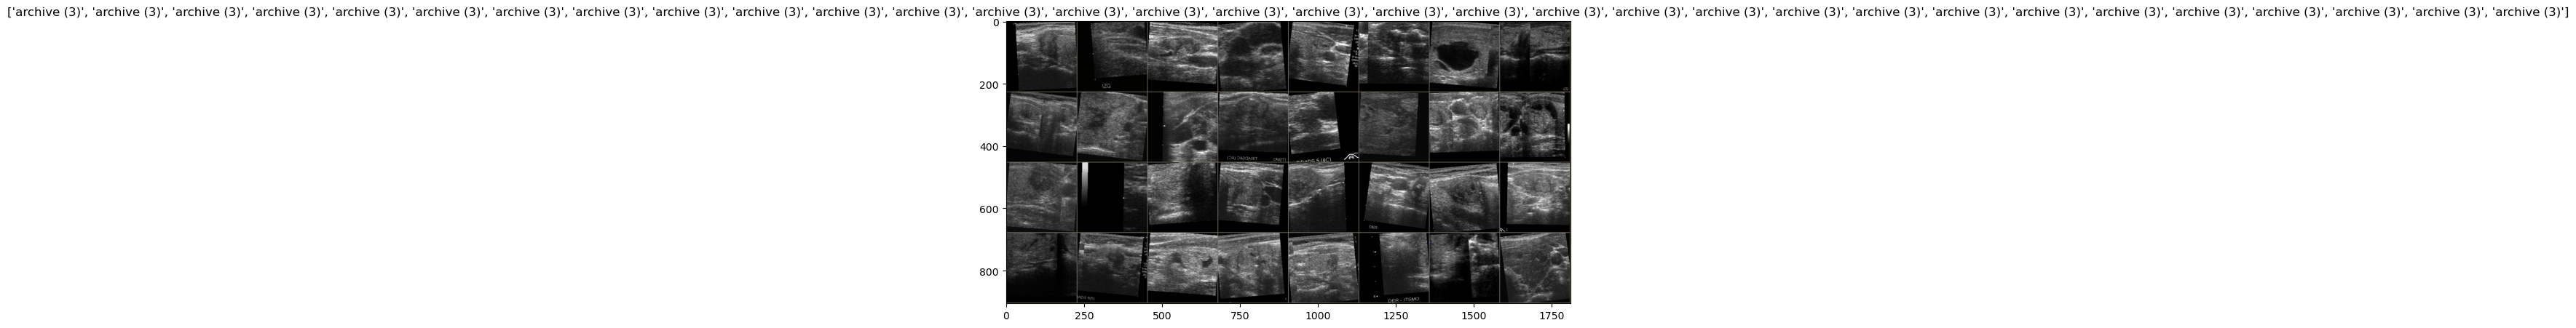

Dataset Statistics:
archive (3): 480 images
Total: 480 images
Epoch 1/25
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0000 Acc: 1.0000
Epoch 2/25
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0000 Acc: 1.0000
Epoch 3/25
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0000 Acc: 1.0000
Epoch 4/25
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0000 Acc: 1.0000
Epoch 5/25
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0000 Acc: 1.0000
Epoch 6/25
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0000 Acc: 1.0000
Early stopping


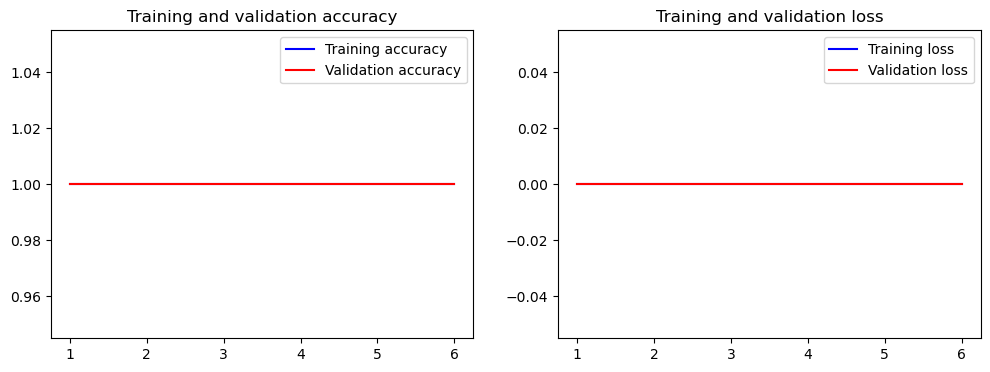

Validation Accuracy: 1.0000


In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import torchvision
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import copy
from PIL import Image
import numpy as np

# カスタムローダー関数
def pil_loader(path):
    try:
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        return None

# デバイスの設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# データ変換
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# ディレクトリの設定
data_dir = '/Users/madoka/trantura_ondisk/kaaglle_thyroid_data'

# データセットの読み込み
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'], loader=pil_loader)

# Noneを返す画像を除外
valid_indices = [i for i, (img, _) in enumerate(full_dataset) if img is not None]
valid_dataset = Subset(full_dataset, valid_indices)

# データローダーの設定
dataloaders = {
    'train': DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=0),
    'val': DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=0)
}
dataset_sizes = {'train': len(valid_dataset), 'val': len(valid_dataset)}
class_names = full_dataset.classes

# データの可視化関数
def imshow(inp, title=None):
    """画像を表示する"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def visualize_dataset(dataloader, class_names):
    #データセットのサンプル画像を表示する
    inputs, classes = next(iter(dataloader))
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# データセットの統計情報表示関数
def print_dataset_stats(dataset):
    #データセットの統計情報を表示する
    if isinstance(dataset, Subset):
        original_dataset = dataset.dataset
        indices = dataset.indices
        classes = original_dataset.classes
        class_counts = {}
        for idx in indices:
            _, label = original_dataset[idx]
            class_name = classes[label]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
    else:
        classes = dataset.classes
        class_counts = {}
        for _, label in dataset:
            class_name = classes[label]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
    
    print("Dataset Statistics:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images")
    print(f"Total: {sum(class_counts.values())} images")

# 早期停止の設定
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# モデルの訓練関数
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    early_stopping = EarlyStopping(patience=5, delta=0.01)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)

                early_stopping(epoch_loss, model)
                if early_stopping.early_stop:
                    print("Early stopping")
                    model.load_state_dict(best_model_wts)
                    return model, history

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model, history

# 訓練履歴をプロットする関数
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_acc'], 'b', label='Training accuracy')
    plt.plot(epochs, history['val_acc'], 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], 'b', label='Training loss')
    plt.plot(epochs, history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# モデルの精度を評価する関数
def evaluate_model(model, dataloader, device):
    model.eval()
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    accuracy = running_corrects.double() / total
    print(f'Validation Accuracy: {accuracy:.4f}')

def main():
    # データの可視化
    plt.figure(figsize=(10, 10))
    visualize_dataset(dataloaders['train'], class_names)
    plt.show()

    # データセットの統計情報を表示
    print_dataset_stats(valid_dataset)

    # 事前学習済みモデルの読み込み
    model_ft = models.resnet50(weights='ResNet50_Weights.DEFAULT')
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, len(class_names))
    )

    model_ft = model_ft.to(device)

    # 損失関数とオプティマイザ
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001, weight_decay=1e-4)

    # 学習率スケジューラ
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    # モデルの訓練
    model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

    # 訓練履歴をプロット
    plot_training_history(history)

    # モデルの評価
    evaluate_model(model_ft, dataloaders['val'], device)

if __name__ == "__main__":
    main()

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def load_data(data_dir):
    print(f"データをロードしています: {data_dir}")
    data = []
    archive_path = os.path.join(data_dir, "archive (3)")
    
    # ディレクトリが存在するか確認
    if not os.path.isdir(archive_path):
        raise ValueError(f"ディレクトリが見つかりません: {archive_path}")

    # 画像ファイルを読み込み、ラベルを設定
    for file in os.listdir(archive_path):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            full_path = os.path.join(archive_path, file)
            label = determine_tirads_label(file)
            data.append([full_path, label])

    df = pd.DataFrame(data, columns=['image_path', 'label'])
    if df.empty:
        raise ValueError("指定されたディレクトリに有効な画像ファイルが見つかりません。")
    return df

def determine_tirads_label(file_name):
    # ファイル名に基づいてTI-RADSラベルを決定
    file_name = file_name.lower()
    if "tirads1" in file_name:
        return '0'
    elif "tirads2" in file_name:
        return '1'
    elif "tirads3" in file_name:
        return '2'
    elif "tirads4" in file_name:
        return '3'
    elif "tirads5" in file_name:
        return '4'
    else:
        return '-1'

def visualize_data(df):
    # ラベルの分布を可視化
    plt.figure(figsize=(8, 6))
    sns.countplot(x='label', data=df)
    plt.title('Label Distribution')
    plt.show()

    # サンプル画像の表示
    sample_images = df.sample(5)
    plt.figure(figsize=(15, 5))
    for i, row in enumerate(sample_images.itertuples()):
        img = plt.imread(row.image_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {row.label}")
        plt.axis('off')
    plt.show()
    
def build_model(input_shape):
    # ResNet50をベースにしたモデルを構築
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(5, activation='softmax')(x)  # TI-RADSの5クラス
    model = Model(inputs=base_model.input, outputs=predictions)

    # ベースモデルの層を凍結
    for layer in base_model.layers:
        layer.trainable = False

    # モデルのコンパイル
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_learning_curves(history):
    # 学習曲線をプロット
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='訓練精度')
    plt.plot(epochs, val_acc, 'b', label='検証精度')
    plt.title('訓練と検証の精度')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='訓練損失')
    plt.plot(epochs, val_loss, 'b', label='検証損失')
    plt.title('訓練と検証の損失')
    plt.legend()

    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    # 混同行列をプロット
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('真のラベル')
    plt.xlabel('予測ラベル')
    plt.title('混同行列')
    plt.show()

def main():
    data_dir = "/Users/madoka/trantura_ondisk/kaaglle_thyroid_data"

    try:
        # データの読み込み
        df = load_data(data_dir)
        print("データセットの概要:")
        print(df.shape)
        print(df['label'].value_counts())

        # データの分割
        train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

        print("\n訓練セットの形状:", train_df.shape)
        print("検証セットの形状:", val_df.shape)

        # データ拡張の設定
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )

        # データジェネレーターの設定
        train_generator = datagen.flow_from_dataframe(
            train_df,
            x_col='image_path',
            y_col='label',
            target_size=(224, 224),
            batch_size=32,
            class_mode='sparse'
        )

        val_generator = datagen.flow_from_dataframe(
            val_df,
            x_col='image_path',
            y_col='label',
            target_size=(224, 224),
            batch_size=32,
            class_mode='sparse'
        )

        # モデルの構築
        model = build_model((224, 224, 3))

        # コールバックの設定
        callbacks = [
            EarlyStopping(patience=10, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.2, patience=5)
        ]

        # モデルのトレーニング
        history = model.fit(
            train_generator,
            epochs=50,
            validation_data=val_generator,
            callbacks=callbacks
        )

        # 学習曲線のプロット
        plot_learning_curves(history)

        # 検証データでの予測
        y_pred = model.predict(val_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = val_generator.classes

        # 分類レポートの表示
        print(classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices.keys()))

        # 混同行列のプロット
        plot_confusion_matrix(y_true, y_pred_classes, classes=val_generator.class_indices.keys())

    except Exception as e:
        print(f"エラーが発生しました: {str(e)}")

if __name__ == "__main__":
    main()

2024-08-17 17:18:44.790131: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


データをロードしています: /Users/madoka/trantura_ondisk/kaaglle_thyroid_data
データセットの概要:
(480, 2)
label
-1    480
Name: count, dtype: int64

訓練セットの形状: (384, 2)
検証セットの形状: (96, 2)
Found 384 validated image filenames belonging to 1 classes.
Found 96 validated image filenames belonging to 1 classes.
Epoch 1/50


/Users/madoka/.pyenv/versions/3.11.0/envs/myenv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 145s 11s/step - accuracy: 0.0663 - loss: 2.2506 - val_accuracy: 0.0000e+00 - val_loss: 1.6244 - learning_rate: 1.0000e-04
Epoch 2/50
 8/12 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step - accuracy: 0.1301 - loss: 1.8748